In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

# read data in 
issues = pd.read_csv('../data/issues.csv', index_col = 0)
roll_calls = pd.read_csv('../data/roll_calls.csv', index_col = 0, na_values=['NA', ''])
unvotes = pd.read_csv('../data/unvotes.csv', index_col = 0)

# print(issues.head(2))
#print(issues.index) #'rcid' column
issues = issues.reset_index(drop=False)

# print(roll_calls.head(2))
#print(roll_calls.index) #'rcid' column
roll_calls = roll_calls.reset_index(drop=False)

#print(unvotes.head(2))
# print(unvotes.index) #'rcid' column
unvotes = unvotes.reset_index(drop=False)

In [2]:
#data checks: issues

"""
rcid is a specific vote session id. 
this table maps the specific topic discussed to a specific vote session id.

note: 
- me: palestinian conflict
- nu: nuclear weapons & nuclear material
- di: arms control & disarmament
- hr: human rights
- co: colonialism
- ec: economic development 

"""

# print("shape: " + str(issues.shape)) #(5745, 3)
# print(issues.describe())
# print(issues.dtypes)
# print(issues.isna().sum()) #no na values
# print(issues.duplicated(subset=['rcid', 'short_name']).sum()) # on rcid and short_name, no duplicates
# print(issues['short_name'].unique()) #['me' 'nu' 'di' 'hr' 'co' 'ec']

issues = issues.drop(columns=['issue'])

In [3]:
#data checks: unvotes

"""
this table describes how each country voted in each voting session. 
"""

# print("shape: " + str(unvotes.shape)) #(869937, 4)
# print(unvotes.describe())
# print(unvotes.dtypes) 
# print(unvotes.isna().sum()) #country code has 7898 missing values 

missing_country = unvotes[unvotes['country_code'].isna()]
# print(missing_country['country'].unique()) #['Yemen Arab Republic' 'Zanzibar' 'Federal Republic of Germany' 'Namibia']
mapping = {'Yemen Arab Republic': 'YAR', 'Zanzibar': 'ZAN', 'Federal Republic of Germany': 'GER', 'Namibia': 'NAM'}
unvotes['country_code'] = unvotes['country'].fillna(unvotes['country'].map(mapping))

# print(unvotes.isna().sum()) #now country code has no missing values
# print(unvotes.duplicated(subset=['rcid', 'country_code']).sum()) # on rcid and country_code, no duplicates

In [4]:
#data checks: roll_calls 

"""
this table describes the details of each vote: date, resolution number, descriptions of what the vote is about.
"""

# print(roll_calls.head(1))
# print("shape: " + str(roll_calls.shape)) #(6202, 9)
# print(roll_calls.describe()) #5598/6164 important votes (of those assessed); 2868 amendment votes, 3208 paragraph votes
# print(roll_calls.duplicated(subset=['rcid']).sum()) #no duplicates
# print(roll_calls.isna().sum()) 

"""
missing values: 
importantvote     604
unres             159
amend            3334
para             2994
short             573
descr               1
"""

# print(roll_calls.dtypes) #convert date to DateTime; importantvote, amend, para left as int/float
roll_calls['date'] = pd.to_datetime(roll_calls['date'], format='%Y-%m-%d')
# print(roll_calls.dtypes)

pre_1985 = roll_calls[roll_calls['date'].between('1946-01-01', '1984-12-31')].sort_values('date', ascending=True)
# print(pre_1985.shape[0]) #2844
# print(pre_1985.isna().sum()) #all cleaned except for 151 missing entries for unres


post_1985 = roll_calls[roll_calls['date'].between('1985-01-01', '2020-01-01')].sort_values('date', ascending=True)
post_1985 = post_1985.drop(columns=['amend', 'para'])
# print(post_1985.head(1))
# print(post_1985.isna().sum()) #missing entries: 604 importantvote, 8 unres, 573 short, 1 descr

pre_no_amend_para = pre_1985[['rcid', 'session', 'importantvote', 'date', 'unres', 'short', 'descr']]
roll_calls_no_amend_para = pd.concat([pre_no_amend_para, post_1985], axis=0)
# print(roll_calls_no_amend_para.shape) #(6202,7) 
# print(roll_calls_no_amend_para.isna().sum()) #missing entries: 604 importantvote, 159 unres, 573 short, 1 descr


In [5]:
### exploration ### 
merged = pd.merge(roll_calls_no_amend_para, issues[['rcid', 'short_name']], on = 'rcid', how = 'left')

print(merged.shape) # (7848, 8)
print(merged['short_name'].value_counts())

(7848, 8)
short_name
di    1092
me    1061
hr    1015
co     957
nu     855
ec     765
Name: count, dtype: int64


/var/folders/pz/r0q11sl90g95ybqhltt1nbvh0000gn/T/ipykernel_75273/530238503.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cold_war.groupby(['period', 'short_name'])
/var/folders/pz/r0q11sl90g95ybqhltt1nbvh0000gn/T/ipykernel_75273/530238503.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  issue_trends['total_per_period'] = issue_trends.groupby('period')['count'].transform('sum') # count per period


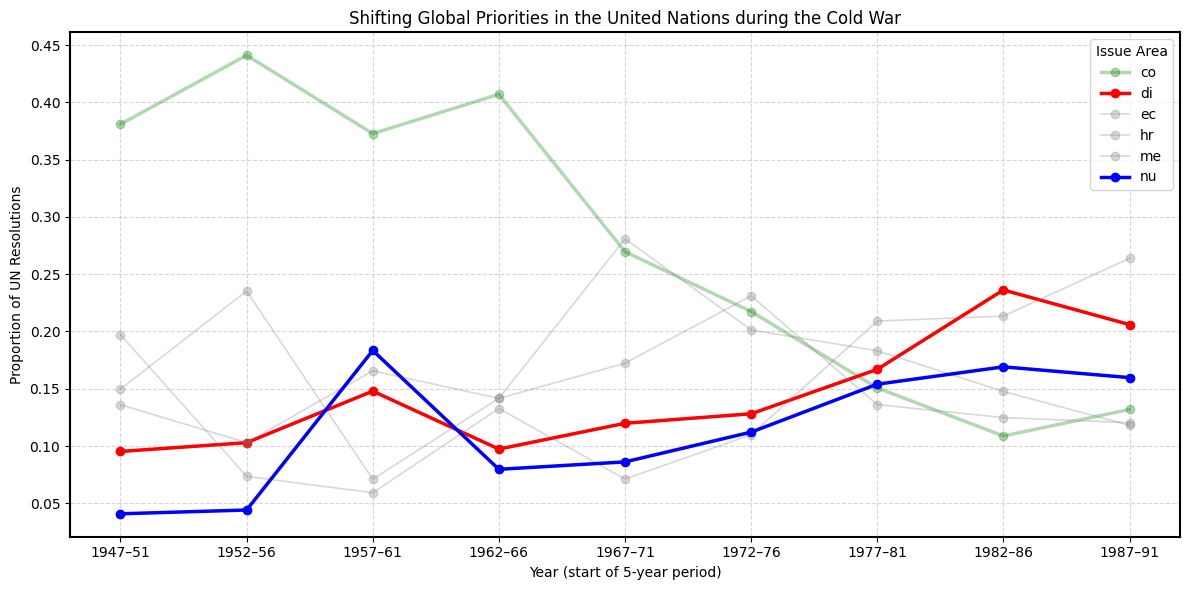

In [34]:
cold_war = merged.query("'1947-01-01' <= date <= '1991-12-31'").copy() # focus on cold war period, dates from chatGPT

bins = list(range(1947, 1997, 5)) # get groups of 5 years 
labels = [f"{y}-{y+4}" for y in bins[:-1]] # get labels corersponding to this list of 5 years 
cold_war['year'] = cold_war['date'].dt.year # new column for the year 
cold_war['period'] = pd.cut(cold_war['year'], bins=bins, labels=labels, right=True) # assigning to each 5 year period

issue_trends = (
    cold_war.groupby(['period', 'short_name'])
    .size()
    .reset_index(name='count')
)
issue_trends['total_per_period'] = issue_trends.groupby('period')['count'].transform('sum') # count per period 
issue_trends['share'] = issue_trends['count'] / issue_trends['total_per_period'] # proportion of period 

#issue_trends['period'] = pd.Categorical(issue_trends['period'], categories=labels, ordered=True) # create categorical variable for the period so it shows correctly 
 # for cleaner x axis 
issue_trends['period_start'] = issue_trends['period'].apply(
    lambda x: f"{str(x)[:4]}–{str(x)[7:9]}" if pd.notna(x) else x
)

plt.figure(figsize=(12,6)) # needs to be before the plot arg
highlighted_issues = ["di", "nu"]
highlighted_alpha = 1.0 # for highlighted issues
other_alpha = 0.3 # for others

for issue, data in issue_trends.groupby('short_name'):
    if issue in highlighted_issues:
        colour = 'red' if issue == 'di' else 'blue'
        plt.plot(data['period_start'], data['share'], marker='o', label=issue, alpha = highlighted_alpha, linewidth = 2.5, color = colour)
    else:
        if issue == 'co':
            plt.plot(data['period_start'], data['share'], marker='o', label=issue, alpha = other_alpha, linewidth = 2.5, color = 'green')
        else:
            plt.plot(data['period_start'], data['share'], marker='o', label=issue, alpha = other_alpha, linewidth = 1.2, color = 'grey')


ax = plt.gca()
for i in ["bottom", "left", "top", "right"]:
    ax.spines[i].set_linewidth(1.5)
plt.title("Shifting Global Priorities in the United Nations during the Cold War")
plt.xlabel("Year (start of 5-year period)")
plt.ylabel("Proportion of UN Resolutions")
plt.legend(title="Issue Area")
plt.xticks(sorted(issue_trends['period_start'].unique()))  # show start years only
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


### change transparency of everyth except di and nu to 0.5 
### fix to make sure that it includes 1987 - end 

# print(issue_trends['period'].unique())  